# 04 - Shape & Piece Detection

## Übersicht 
Dieses Notebook zeigt die Schritte der Pipeline zur Erkennung von Puzzle-Teilen und dem Rahmen:

1. **Image Loading & Preprocessing** - Bild laden und vorbereiten (Grayscale, Blur, Threshold)
2. **Shape Detection (Sobel)** - Kantenerkennung mit Sobel-Operator
3. **Piece Detection** - Konturen finden und in Frame/Pieces aufteilen
4. **Visualisierung** - Ergebnisse darstellen

### Installation von packages

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### 1. Image Loading & Preprocessing
Das Bild wird geladen und mit der im **01 - Image Preprocessing** definierten Methode vorbereitet:
- Grayscale Conversion
- Gaussian Blur (5x5)
- Otsu's Threshold

Diese Logik ist in `ImageLoader.__clean()` implementiert:

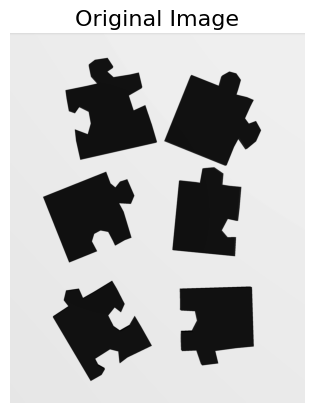

Shape: (2586, 2064, 3)


In [19]:
image_path = '../data/image-007.png'
image_raw = cv2.imread(image_path)

plt.imshow(cv2.cvtColor(image_raw, cv2.COLOR_BGR2RGB))
plt.title('Original Image', fontsize=16)
plt.axis('off')
plt.show()

print(f'Shape: {image_raw.shape}')

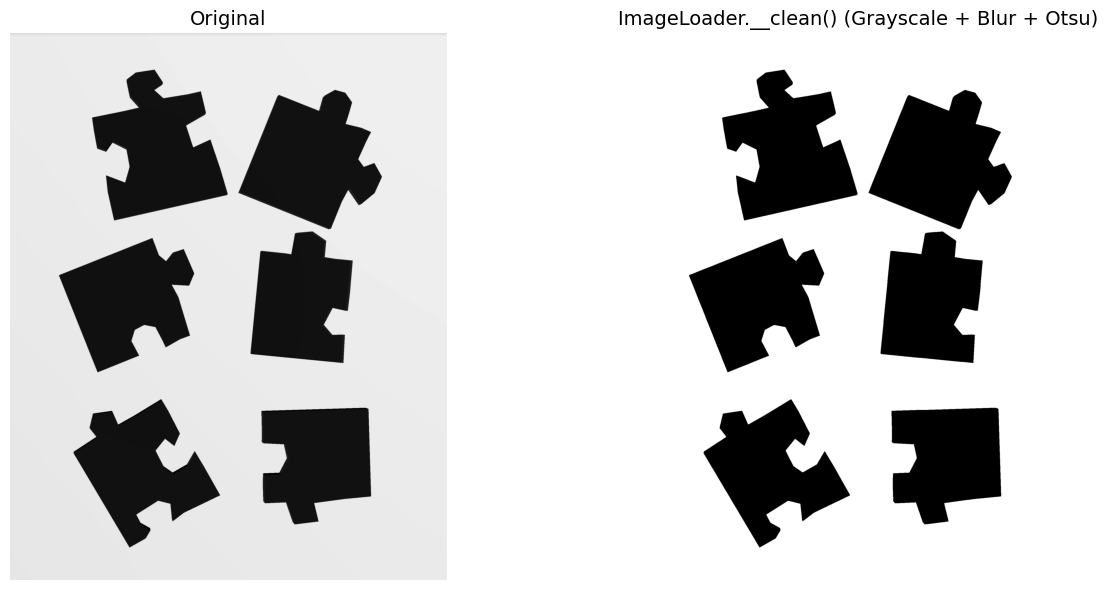

Preprocessed Shape: (2586, 2064)


In [20]:
# === ImageLoader.__clean() ===
# Quelle: solver/pipeline/image_loader.py

def image_loader_clean(image):
    """Preprocessing: Grayscale -> Gaussian Blur -> Otsu Threshold"""
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(grayscale, (5, 5), 0)
    
    _, threshold = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return threshold

image_preprocessed = image_loader_clean(image_raw)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(cv2.cvtColor(image_raw, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original', fontsize=14)
axes[0].axis('off')

axes[1].imshow(image_preprocessed, cmap='gray')
axes[1].set_title('ImageLoader.__clean() (Grayscale + Blur + Otsu)', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f'Preprocessed Shape: {image_preprocessed.shape}')

### 2. Shape Detection (Sobel)
Der `ShapeDetector` verwendet den Sobel-Operator zur Kantenerkennung. Wie im **02 - Edge Detection** Notebook gezeigt, bietet Sobel einen guten Kompromiss zwischen Qualität und Performance.

Der Sobel-Operator berechnet:
- Gradient in X-Richtung (vertikale Kanten)
- Gradient in Y-Richtung (horizontale Kanten)
- Kombiniert beide zu einem Gesamtgradienten

In [21]:
# === ShapeDetector.detect() ===
# Quelle: solver/pipeline/shape_detector.py

def shape_detector_detect(image):
    """Sobel Edge Detection"""
    gradient_x = cv2.Sobel(image, cv2.CV_16S, 1, 0)
    gradient_y = cv2.Sobel(image, cv2.CV_16S, 0, 1)

    gradient_x_abs = np.abs(gradient_x)
    gradient_y_abs = np.abs(gradient_y)

    return np.minimum(gradient_x_abs + gradient_y_abs, 255).astype(np.uint8)

image_edges = shape_detector_detect(image_preprocessed)

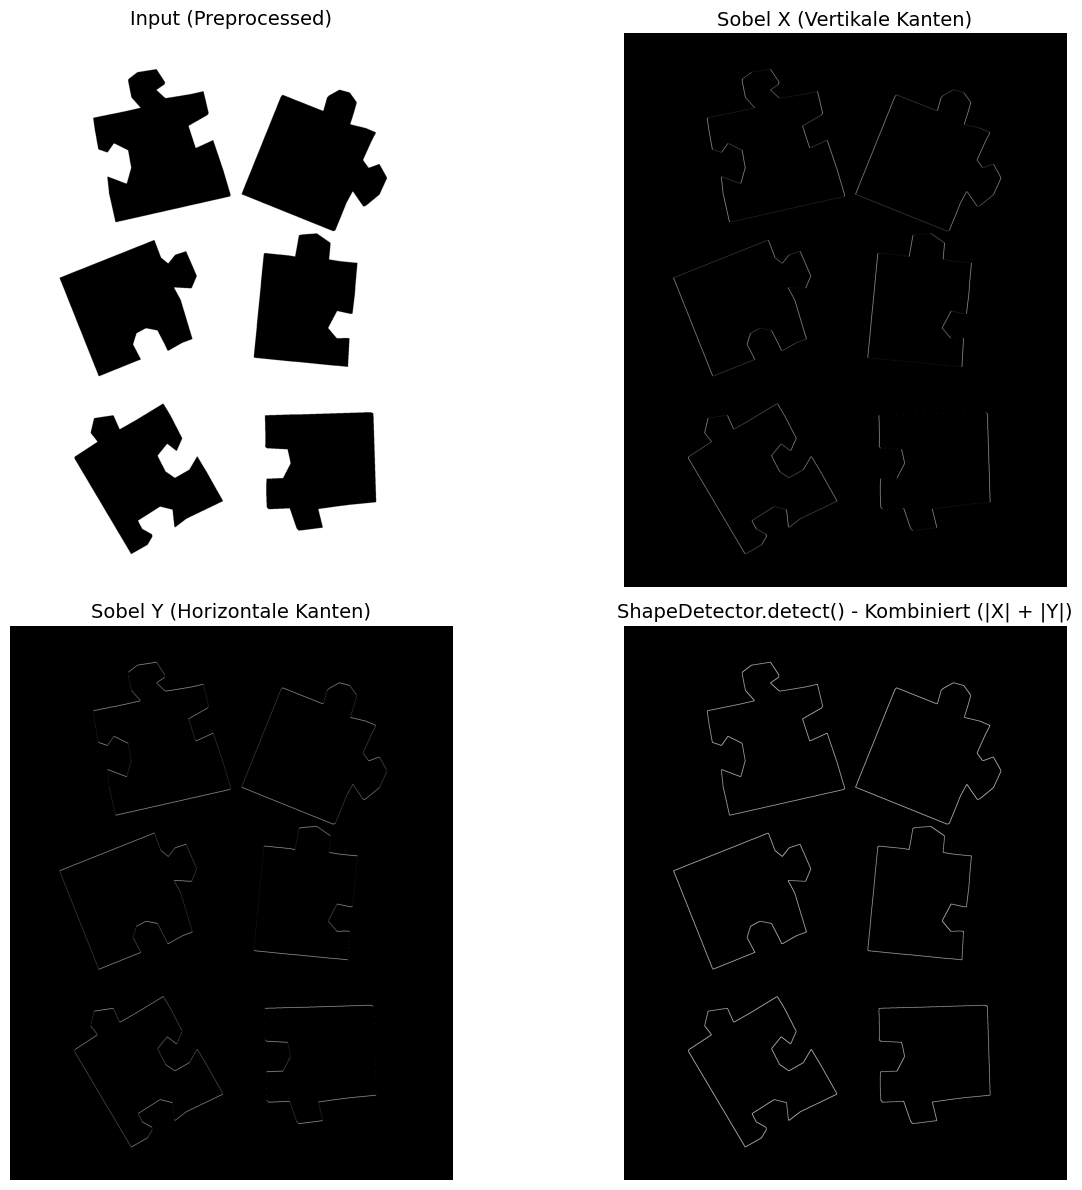

In [22]:
# Visualisierung der einzelnen Gradienten
gradient_x = cv2.Sobel(image_preprocessed, cv2.CV_16S, 1, 0)
gradient_y = cv2.Sobel(image_preprocessed, cv2.CV_16S, 0, 1)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

axes[0, 0].imshow(image_preprocessed, cmap='gray')
axes[0, 0].set_title('Input (Preprocessed)', fontsize=14)
axes[0, 0].axis('off')

axes[0, 1].imshow(np.abs(gradient_x), cmap='gray')
axes[0, 1].set_title('Sobel X (Vertikale Kanten)', fontsize=14)
axes[0, 1].axis('off')

axes[1, 0].imshow(np.abs(gradient_y), cmap='gray')
axes[1, 0].set_title('Sobel Y (Horizontale Kanten)', fontsize=14)
axes[1, 0].axis('off')

axes[1, 1].imshow(image_edges, cmap='gray')
axes[1, 1].set_title('ShapeDetector.detect() - Kombiniert (|X| + |Y|)', fontsize=14)
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

### 3. Piece Detection
Der `PieceDetector` findet alle Konturen im Bild und trennt diese in:
- **Frame**: Die Kontur, die den linken Bildrand berührt (innerhalb von 30% der Bildbreite)
- **Pieces**: Alle anderen Konturen sind Puzzle-Teile

Für den Frame wird mittels `cv2.minAreaRect` das minimale umschliessende Rechteck berechnet.

In [23]:
# === Hilfsfunktionen aus PolygonUtility ===
# Quelle: solver/utility/polygon.py

def get_frame(points):
    """Berechnet das minimale umschliessende Rechteck und gibt die Eckpunkte zurück"""
    points = np.array(points, dtype=np.float32)
    
    rectangle = cv2.minAreaRect(points)
    box = cv2.boxPoints(rectangle)
    
    s = box.sum(axis=1)
    diff = np.diff(box, axis=1)
    
    topLeft = box[np.argmin(s)]
    bottomRight = box[np.argmax(s)]
    topRight = box[np.argmin(diff)]
    bottomLeft = box[np.argmax(diff)]
    
    return {
        'topLeft': (float(topLeft[0]), float(topLeft[1])),
        'topRight': (float(topRight[0]), float(topRight[1])),
        'bottomLeft': (float(bottomLeft[0]), float(bottomLeft[1])),
        'bottomRight': (float(bottomRight[0]), float(bottomRight[1]))
    }

def calculate_center_of_mass(points):
    """Berechnet den Schwerpunkt eines Polygons"""
    area = 0.0
    cx = 0.0
    cy = 0.0
    n = len(points)

    for i in range(n):
        current = points[i]
        next_point = points[(i + 1) % n]
        cross = current[0] * next_point[1] - next_point[0] * current[1]
        area += cross
        cx += (current[0] + next_point[0]) * cross
        cy += (current[1] + next_point[1]) * cross

    area *= 0.5
    if area == 0:
        return (np.mean([p[0] for p in points]), np.mean([p[1] for p in points]))
    cx /= (6 * area)
    cy /= (6 * area)

    return (cx, cy)

In [24]:
# === PieceDetector.detect() ===
# Quelle: solver/pipeline/piece_detector.py

FRAME_WIDTH_PERCENTAGE = 30

def piece_detector_detect(image):
    """Findet Konturen und trennt sie in Frame und Pieces"""
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # Define boundary for frame
    left_boundary = int(image.shape[1] * FRAME_WIDTH_PERCENTAGE / 100)
    
    frame = None
    pieces = []
    
    for contour in contours:
        # Convert contour to Nx2 array
        coordinates = contour.reshape(-1, 2)
        
        # Check if contour touches left boundary -> Frame
        if np.any(coordinates[:, 0] < left_boundary):
            frame = get_frame(coordinates)
            frame['contour'] = contour  # Keep original contour for visualization
        else:
            # Piece
            center = calculate_center_of_mass(coordinates)
            pieces.append({
                'points': coordinates,
                'contour': contour,
                'center_of_mass': center
            })
    
    return frame, pieces

frame, pieces = piece_detector_detect(image_edges)

print(f'Frame gefunden: {frame is not None}')
print(f'Anzahl Pieces: {len(pieces)}')

Frame gefunden: True
Anzahl Pieces: 3


### 3.1 Frame vs. Pieces Separation
Der Frame wird identifiziert, indem geprüft wird, welche Kontur den linken Bildbereich (< 30% der Breite) berührt.

In [25]:
left_boundary = int(image_edges.shape[1] * FRAME_WIDTH_PERCENTAGE / 100)

print(f'Bildbreite: {image_edges.shape[1]} px')
print(f'FRAME_WIDTH_PERCENTAGE: {FRAME_WIDTH_PERCENTAGE}%')
print(f'Frame-Grenze: {left_boundary} px')
print(f'\nKonturen links der Grenze werden als Frame erkannt.')

Bildbreite: 2064 px
FRAME_WIDTH_PERCENTAGE: 30%
Frame-Grenze: 619 px

Konturen links der Grenze werden als Frame erkannt.


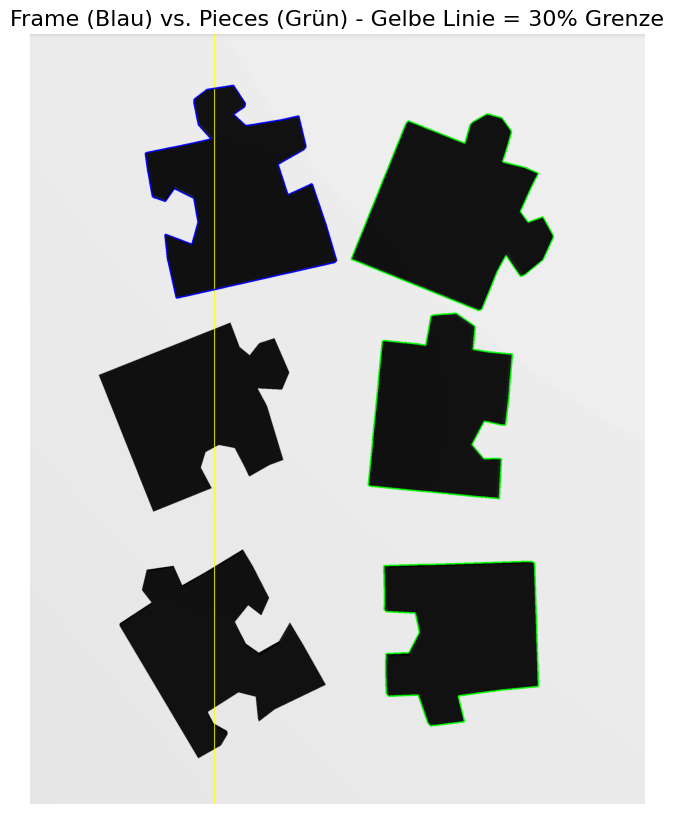

In [26]:
# Visualisierung Frame vs. Pieces
separation_image = cv2.cvtColor(image_raw.copy(), cv2.COLOR_BGR2RGB)

# Frame-Grenze einzeichnen
cv2.line(separation_image, (left_boundary, 0), (left_boundary, image_edges.shape[0]), (255, 255, 0), 2)

# Frame in Blau
if frame is not None:
    cv2.drawContours(separation_image, [frame['contour']], -1, (0, 0, 255), 3)

# Pieces in Grün
for piece in pieces:
    cv2.drawContours(separation_image, [piece['contour']], -1, (0, 255, 0), 3)

plt.figure(figsize=(14, 10))
plt.imshow(separation_image)
plt.title('Frame (Blau) vs. Pieces (Grün) - Gelbe Linie = 30% Grenze', fontsize=16)
plt.axis('off')
plt.show()

### 3.2 Frame Analyse (PuzzleFrame)
Der `PieceDetector` extrahiert die vier Eckpunkte des Frames mittels `cv2.minAreaRect()`.

In [27]:
if frame is not None:
    print('PuzzleFrame Eckpunkte:')
    print(f"  topLeft:     ({frame['topLeft'][0]:.1f}, {frame['topLeft'][1]:.1f})")
    print(f"  topRight:    ({frame['topRight'][0]:.1f}, {frame['topRight'][1]:.1f})")
    print(f"  bottomLeft:  ({frame['bottomLeft'][0]:.1f}, {frame['bottomLeft'][1]:.1f})")
    print(f"  bottomRight: ({frame['bottomRight'][0]:.1f}, {frame['bottomRight'][1]:.1f})")
    
    # Dimensionen berechnen
    width = np.linalg.norm(np.array(frame['topRight']) - np.array(frame['topLeft']))
    height = np.linalg.norm(np.array(frame['bottomLeft']) - np.array(frame['topLeft']))
    print(f'\nFrame Dimensionen:')
    print(f'  Breite: {width:.1f} px')
    print(f'  Höhe:   {height:.1f} px')

PuzzleFrame Eckpunkte:
  topLeft:     (339.6, 245.3)
  topRight:    (878.1, 118.8)
  bottomLeft:  (491.5, 891.9)
  bottomRight: (1030.0, 765.4)

Frame Dimensionen:
  Breite: 553.1 px
  Höhe:   664.2 px


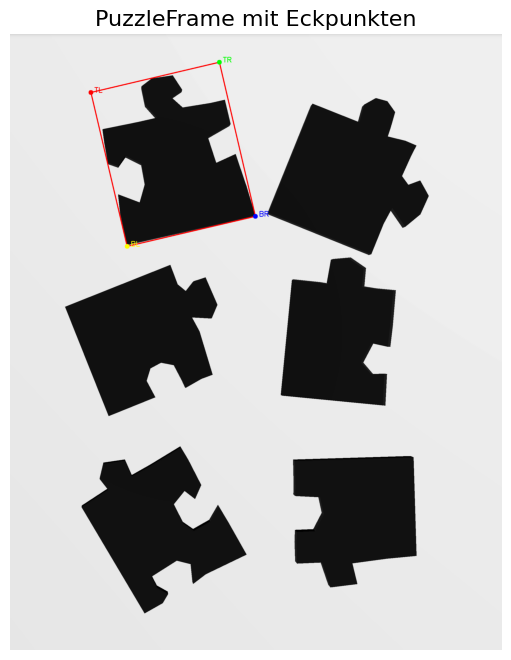

In [28]:
# Frame Visualisierung
if frame is not None:
    frame_image = cv2.cvtColor(image_raw.copy(), cv2.COLOR_BGR2RGB)
    
    # Rechteck aus Frame Eckpunkten zeichnen
    corners = [
        (int(frame['topLeft'][0]), int(frame['topLeft'][1])),
        (int(frame['topRight'][0]), int(frame['topRight'][1])),
        (int(frame['bottomRight'][0]), int(frame['bottomRight'][1])),
        (int(frame['bottomLeft'][0]), int(frame['bottomLeft'][1]))
    ]
    
    # Linien zeichnen
    for i in range(4):
        cv2.line(frame_image, corners[i], corners[(i+1) % 4], (255, 0, 0), 3)
    
    # Eckpunkte markieren
    labels = ['TL', 'TR', 'BR', 'BL']
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
    
    for i, (corner, label, color) in enumerate(zip(corners, labels, colors)):
        cv2.circle(frame_image, corner, 10, color, -1)
        cv2.putText(frame_image, label, (corner[0] + 15, corner[1]), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(frame_image)
    plt.title('PuzzleFrame mit Eckpunkten', fontsize=16)
    plt.axis('off')
    plt.show()

### 3.3 Pieces Analyse
Für jedes Puzzle-Teil wird der Schwerpunkt (Center of Mass) berechnet. Dieser dient als Greifpunkt für den Roboter.

In [29]:
for i, piece in enumerate(pieces):
    print(f'Piece {i}:')
    print(f'  Punkte: {len(piece["points"])}')
    print(f'  Center of Mass: ({piece["center_of_mass"][0]:.1f}, {piece["center_of_mass"][1]:.1f})')
    print()

Piece 0:
  Punkte: 2190
  Center of Mass: (1453.0, 2010.4)

Piece 1:
  Punkte: 2150
  Center of Mass: (1371.3, 1270.2)

Piece 2:
  Punkte: 2211
  Center of Mass: (1419.9, 602.5)



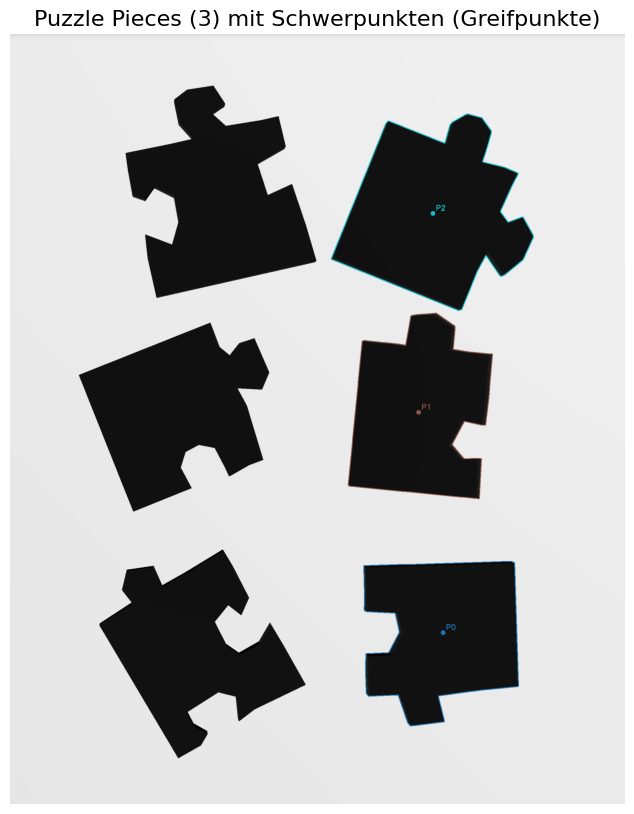

In [30]:
# Pieces mit Schwerpunkten visualisieren
pieces_image = cv2.cvtColor(image_raw.copy(), cv2.COLOR_BGR2RGB)

colors = plt.cm.tab10(np.linspace(0, 1, max(len(pieces), 1)))

for i, piece in enumerate(pieces):
    color = tuple(int(c * 255) for c in colors[i][:3])
    
    # Kontur zeichnen
    cv2.drawContours(pieces_image, [piece['contour']], -1, color, 2)
    
    # Schwerpunkt markieren
    center = (int(piece['center_of_mass'][0]), int(piece['center_of_mass'][1]))
    cv2.circle(pieces_image, center, 8, color, -1)
    cv2.putText(pieces_image, f'P{i}', (center[0] + 10, center[1] - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

plt.figure(figsize=(14, 10))
plt.imshow(pieces_image)
plt.title(f'Puzzle Pieces ({len(pieces)}) mit Schwerpunkten (Greifpunkte)', fontsize=16)
plt.axis('off')
plt.show()

### 4. Pipeline Zusammenfassung
Hier ist die komplette Pipeline visualisiert:

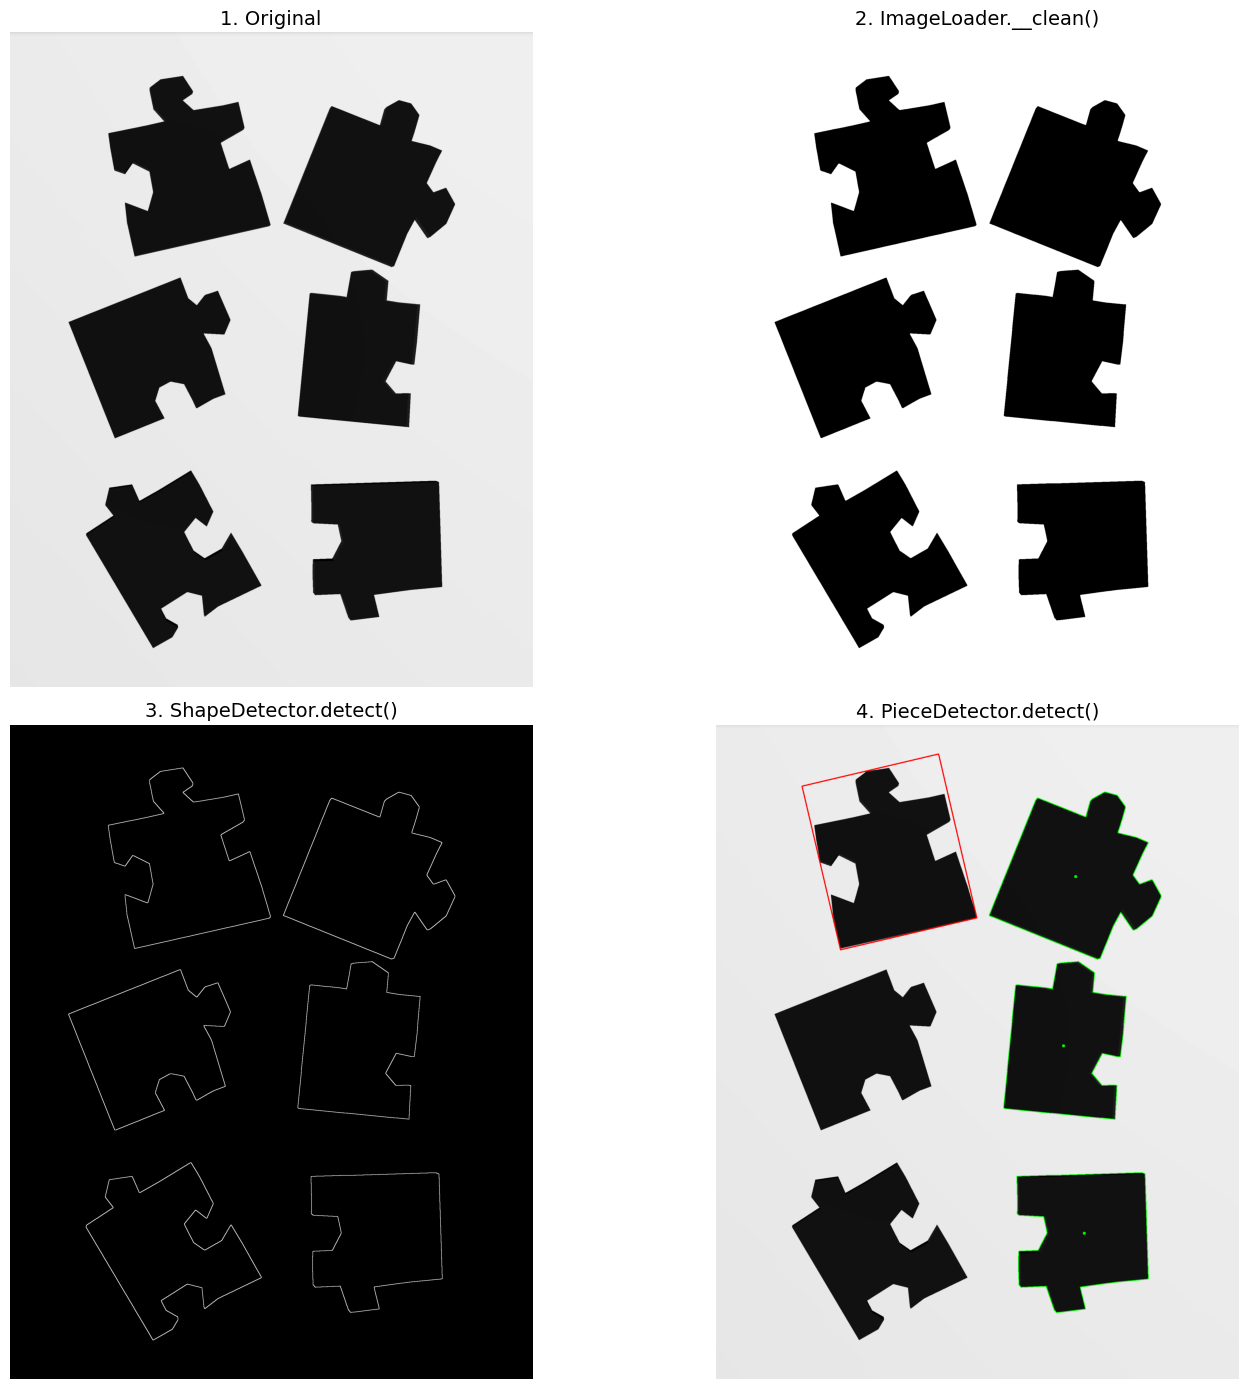

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Original
axes[0, 0].imshow(cv2.cvtColor(image_raw, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('1. Original', fontsize=14)
axes[0, 0].axis('off')

# 2. ImageLoader (Preprocessed)
axes[0, 1].imshow(image_preprocessed, cmap='gray')
axes[0, 1].set_title('2. ImageLoader.__clean()', fontsize=14)
axes[0, 1].axis('off')

# 3. ShapeDetector (Edge Detection)
axes[1, 0].imshow(image_edges, cmap='gray')
axes[1, 0].set_title('3. ShapeDetector.detect()', fontsize=14)
axes[1, 0].axis('off')

# 4. PieceDetector (Final Result)
final_image = cv2.cvtColor(image_raw.copy(), cv2.COLOR_BGR2RGB)

# Frame zeichnen
if frame is not None:
    corners = [
        (int(frame['topLeft'][0]), int(frame['topLeft'][1])),
        (int(frame['topRight'][0]), int(frame['topRight'][1])),
        (int(frame['bottomRight'][0]), int(frame['bottomRight'][1])),
        (int(frame['bottomLeft'][0]), int(frame['bottomLeft'][1]))
    ]
    for i in range(4):
        cv2.line(final_image, corners[i], corners[(i+1) % 4], (255, 0, 0), 3)

# Pieces zeichnen
for piece in pieces:
    cv2.drawContours(final_image, [piece['contour']], -1, (0, 255, 0), 2)
    center = (int(piece['center_of_mass'][0]), int(piece['center_of_mass'][1]))
    cv2.circle(final_image, center, 6, (0, 255, 0), -1)

axes[1, 1].imshow(final_image)
axes[1, 1].set_title('4. PieceDetector.detect()', fontsize=14)
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

### Zusammenfassung

Die Pipeline besteht aus drei Hauptschritten:

**1. ImageLoader.__clean()** (`solver/pipeline/image_loader.py`)
```python
grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(grayscale, (5, 5), 0)
_, threshold = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
```

**2. ShapeDetector.detect()** (`solver/pipeline/shape_detector.py`)
```python
gradient_x = cv2.Sobel(image, cv2.CV_16S, 1, 0)
gradient_y = cv2.Sobel(image, cv2.CV_16S, 0, 1)
return np.minimum(np.abs(gradient_x) + np.abs(gradient_y), 255).astype(np.uint8)
```

**3. PieceDetector.detect()** (`solver/pipeline/piece_detector.py`)
```python
contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
left_boundary = int(image.shape[1] * 30 / 100)  # 30% Grenze

for contour in contours:
    if np.any(coordinates[:, 0] < left_boundary):
        frame = ...  # minAreaRect für Eckpunkte
    else:
        pieces.append(...)  # Center of Mass berechnen
```